# Packages

In [1]:
#%%capture
!pip install wget
!pip install wandb
!pip install plot_keras_history
!pip install tensorflow-addons
!jupyter nbextension enable --py widgetsnbextension

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
!mkdir saved_images

/bin/bash: /home/ngoc/anaconda3/envs/py37/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [4]:
import pandas as pd
import cv2
import wget
import shutil
from tensorflow.keras.applications import VGG16
from tqdm.auto import tqdm
from joblib import Parallel, delayed
from collections import defaultdict
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from PIL import Image
import re
import json
import numpy as np
from plot_keras_history import show_history, plot_history


import tensorflow as tf
from tensorflow import keras
import tensorflow
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers
import tensorflow_addons as tfa
import random
from wandb.keras import WandbCallback
import wandb
import time
from keras import backend as K


2022-11-18 16:49:34.353276: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
!wget https://github.com/Toloka/WSDMCup2023/raw/main/train.csv

In [6]:
DATA_DIR = "/home/ngoc/data/WSDM2023/" # change to /content/ if running on GG COLAB
VISUALIZATION = False  
BATCH_SIZE = 4              
NUM_EPOCHS = 50           
IMAGE_EMBEDIND_SIZE = 1024     
WORD_EMBEDING_SIZE = 300        
NUMBER_FC_LAYER = 2           
HIDDEN_FC_SIZE = 1024        
TEST_TRAINING  = False                       
LEARNING_RATE =0.00001         
MODEL = "VQA"                      
IMAGE_SIZE = 640
LOSS = "MSLE"

In [7]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [8]:

import wandb
wandb.init(project="WSDM2023",
           entity="ngocdunghuynh",
            config = {
                "learning_rate": LEARNING_RATE,
                "epochs": NUM_EPOCHS,
                "batch_size": BATCH_SIZE,
                "loss_function": LOSS,
            })
#WandB key: 40448fdd0d7d5dd051f607a1fcdec27cd9b84996

wandb: Currently logged in as: ngocdunghuynh. Use `wandb login --relogin` to force relogin


# Data Loader

In [9]:
train = pd.read_csv(DATA_DIR  + 'train.csv')
TRAIN_IMGS_DIR = DATA_DIR + "train_imgs/"

In [10]:
# Download data
try:
    os.mkdir(TRAIN_IMGS_DIR)
    img_paths = Parallel(
    n_jobs=100)(delayed(wget.download)(img_url, out= TRAIN_IMGS_DIR) for img_url in tqdm(train.image)
    )
except:
    print("the training set has been downloaded")

the training set has been downloaded


In [11]:
#Get the image path from URL
train.image  = train.image.apply(lambda x: str(x.split("/")[-1]))
train.image  = train.image.apply(lambda x: TRAIN_IMGS_DIR + str(x))

In [12]:
#Spit the original training set into 2 dataframes
train_sample = int(len(train)*0.8)
df_train = train[:int(len(train)*0.8)]
df_val = train[int(len(train)*0.8):]

df_train = df_train.reset_index(drop =True)
df_val = df_val.reset_index(drop =True)

if TEST_TRAINING:
    df_train = df_train[:800*BATCH_SIZE]
    df_val =  df_val[:80*BATCH_SIZE]

## Image Processing

In [13]:
%pylab inline
from concurrent.futures import process


def create_mask(bb, x):
    """Creates a mask for the bounding box of same shape as image"""
    cols, rows,*_ = x.shape
    Y = np.zeros((cols, rows))
    bb = bb.astype(np.int64)
    Y[bb[1]:bb[3], bb[0]:bb[2]] = 1.
    return Y

def mask_to_bb(Y):
    """Convert mask Y to a bounding box, assumes 0 as background nonzero object"""
    rows , cols = np.nonzero(Y)
    if len(cols)==0: 
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.int64)

def xyxy2xywh(box): #Convert box format [xmin ymin xmax ymax] --> [x center, y center, width, height] and normalize the box
    xmin, ymin, xmax, ymax = box
    w = xmax - xmin         # Width of the box
    h = ymax - ymin         # Height of the box
    x_center = (xmin + (w/2))/IMAGE_SIZE 
    y_center = (ymin + (h/2))/IMAGE_SIZE 
    new_w = w/ IMAGE_SIZE 
    new_h = h/IMAGE_SIZE
    return np.array([x_center,y_center, new_w, new_h], dtype=np.float32)

def resize_image_bb(img_path,bb,sz, question, show_example):
    """Resize an image and its bounding box and write image to new path"""
    img = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)
    mask = create_mask(bb, img)
    if show_example:
        result = img.copy()
        cv2.rectangle(result, (bb[0], bb[1]), (bb[2], bb[3]), (0, 255, 0), 5)
        plt.figure()
        plt.title("Original Image")
        plt.xlabel(f"{question} \n bb: {bb}")
        plt.imshow(result)
        plt.show
    
    img_resized = cv2.resize(img, (sz, sz))
    mask_resized = cv2.resize(mask, (sz, sz))
    bb_resized = mask_to_bb(mask_resized)
    x_center,y_center, new_w, new_h = xyxy2xywh(bb_resized)
    processed_box = np.array([x_center,y_center, new_w, new_h], dtype=np.float32)
    if show_example:

        new_result = img_resized.copy()
        cv2.rectangle(new_result, (bb_resized[0], bb_resized[1]), (bb_resized[2], bb_resized[3]), (0, 255, 0), 5)
        plt.figure()
        plt.title("Resized Image")
        plt.imshow(new_result)
        plt.xlabel(f"{question} \n bb: {bb_resized} \n processed_box: {processed_box}")
        plt.show
    return np.array(img_resized, dtype = np.float32), bb_resized, processed_box



def xywh2xyxy(box): #Convert box format [x center, y center, width, height]  --> [xmin ymin xmax ymax] and normalize the box
    x_center,y_center, new_w, new_h = box*IMAGE_SIZE
    xmin = x_center - (new_w/2)
    ymin = y_center - (new_h/2)
    xmax = x_center + (new_w/2)
    ymax = y_center + (new_h/2)
    return np.array([xmin, ymin, xmax, ymax], dtype=np.int64)

def image_box_processing(image_path, box, question = None, show_example = True):
        img_resized, bb_resized , processed_box = resize_image_bb(image_path, box,IMAGE_SIZE, question, show_example)
        return img_resized, bb_resized, processed_box

Populating the interactive namespace from numpy and matplotlib


/home/ngoc/anaconda3/envs/tf/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Question Processing

In [14]:
class Text_Dict:

    """Aim to convert index to word or word to index"""

    def __init__(self, vocab):
        
        self.word_list = vocab
        self.word2idx_dict = {w:n_w for n_w, w in enumerate(self.word_list)}
        self.vocab_size = len(self.word_list)
        self.unk2idx = self.word2idx_dict['<unk>'] if '<unk>' in self.word2idx_dict else None

    def idx2word(self, n_w):

        return self.word_list[n_w]

    def word2idx(self, w):
        if w in self.word2idx_dict:
            return self.word2idx_dict[w]
        elif self.unk2idx is not None:
            return self.unk2idx
        else:
            raise ValueError(f'word {w} not in dictionary (while dictionary does not contain <unk>)')

    def tokenize_and_index(self, sentence):
        inds = [self.word2idx(w) for w in tokenize(sentence)]

        return inds

## Data Pipeline Loaders

In [15]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, dataset, question_vocab, batch_size=32):
        'Initialization'
        self.dataset = dataset
        self.batch_size = batch_size
        self.question_vocab = question_vocab
        self.question_dict = Text_Dict(self.question_vocab)
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.dataset) / self.batch_size))


    def make_vocab_questions(self, questions):
        """Make dictionary for questions and save them into text file."""

        print("- Creating a vocab list for questions")
        vocab_set = set()
        SENTENCE_SPLIT_REGEX = re.compile(r'(\W+)')
        question_length = []

        set_question_length = [None]*len(questions)
        for iquestion, question in enumerate(questions):
            words = SENTENCE_SPLIT_REGEX.split(question.lower())
            words = [w.strip() for w in words if len(w.strip()) > 0]
            vocab_set.update(words)
            set_question_length[iquestion] = len(words)
        question_length += set_question_length

        vocab_list = list(vocab_set)
        vocab_list.sort()
        vocab_list.insert(0, '')
        vocab_list.insert(1, '')
        print(f'    + The size of Question vocabbulary {len(vocab_list)}.')
        print(f'    + Maximum length of question: {np.max(question_length)}')
        return vocab_list


    def tokenize(self, sentence):

        """Split string lines into lists"""
        
        SENTENCE_SPLIT_REGEX = re.compile(r'(\W+)')
        tokens = SENTENCE_SPLIT_REGEX.split(sentence.lower())
        tokens = [t.strip() for t in tokens if len(t.strip()) > 0]
        return tokens

    def question_processing(self, question):
        question_token = self.tokenize(question)
        question_2_idx = [self.question_dict.word2idx(w) for w in question_token ]
        return  question_2_idx
    


    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.dataset))



    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        batch_data = [self.dataset.iloc[k] for k in indexes]
        images, questions, boxes = self.__data_generation(batch_data)
        return [{
            'input_image': np.array(images, dtype =np.float32),
            'input_question': np.array(questions, dtype =int)},
            {"output": np.array(boxes, dtype =np.float32)}]

    def __data_generation(self, batch_data):
        images = []
        questions = []
        boxes = []
        question_len = []
        for image_path, width, hieght, left, top, right, bottom, question in batch_data:
            box = np.array([left, top, right, bottom],dtype = np.float32)
            resized_image, resized_box, processed_box = image_box_processing(image_path, box, question = None, show_example = False)

            question = self.question_processing(question)
            question_len.append(len(question))

            questions.append(question)
            boxes.append(processed_box)
            images.append(resized_image/225)
        questions = pad_sequences(questions, maxlen = max(question_len), dtype='float32', value=0, padding='pre')
        return images, questions, boxes


In [16]:
def make_vocab_questions(questions):
        """Make dictionary for questions and save them into text file."""

        print("- Creating a vocab list for questions")
        vocab_set = set()
        SENTENCE_SPLIT_REGEX = re.compile(r'(\W+)')
        question_length = []

        set_question_length = [None]*len(questions)
        for iquestion, question in enumerate(questions):
            words = SENTENCE_SPLIT_REGEX.split(question.lower())
            words = [w.strip() for w in words if len(w.strip()) > 0]
            vocab_set.update(words)
            set_question_length[iquestion] = len(words)
        question_length += set_question_length

        vocab_list = list(vocab_set)
        vocab_list.sort()
        vocab_list.insert(0, '')
        vocab_list.insert(1, '')
        print(f'    + The size of Question vocabbulary {len(vocab_list)}.')
        print(f'    + Maximum length of question: {np.max(question_length)}')
        return vocab_list

In [17]:
question_vocab = make_vocab_questions(train["question"])

- Creating a vocab list for questions
    + The size of Question vocabbulary 7494.
    + Maximum length of question: 41


# Model

In [19]:
def iou(y_true, y_pred, xyxy = False):
    # iou as metric for bounding box regression
    
    if not xyxy:
        # convert input to be as [x1, y1, x2, y2]
        y_true = y_true*IMAGE_SIZE
        y_true_xmin, y_true_ymin  = y_true[:,0] - y_true[:,2]/2, y_true[:,1] - y_true[:,3]/2
        y_true_xmax, y_true_ymax  = y_true[:,0] + y_true[:,2]/2, y_true[:,1] + y_true[:,3]/2
        y_true = tf.stack([y_true_xmin, y_true_ymin, y_true_xmax, y_true_ymax], 1)
    
        # convert predictions to be as [x1, y1, x2, y2]
        y_pred = y_pred*IMAGE_SIZE
        y_pred_xmin, y_pred_ymin  = y_pred[:,0] - y_pred[:,2]/2, y_pred[:,1] - y_pred[:,3]/2
        y_pred_xmax, y_pred_ymax  = y_pred[:,0] + y_pred[:,2]/2, y_pred[:,1] + y_pred[:,3]/2
        y_pred = tf.stack([y_pred_xmin, y_pred_ymin, y_pred_xmax, y_pred_ymax], 1)
    # AOG = Area of Groundtruth box
    AoG = K.abs(K.transpose(y_true)[2] - K.transpose(y_true)[0] + 1) * K.abs(K.transpose(y_true)[3] - K.transpose(y_true)[1] + 1)
    # AOP = Area of Predicted box
    AoP = K.abs(K.transpose(y_pred)[2] - K.transpose(y_pred)[0] + 1) * K.abs(K.transpose(y_pred)[3] - K.transpose(y_pred)[1] + 1)

    # overlaps are the co-ordinates of intersection box
    overlap_0 = K.maximum(K.transpose(y_true)[0], K.transpose(y_pred)[0])
    overlap_1 = K.maximum(K.transpose(y_true)[1], K.transpose(y_pred)[1])
    overlap_2 = K.minimum(K.transpose(y_true)[2], K.transpose(y_pred)[2])
    overlap_3 = K.minimum(K.transpose(y_true)[3], K.transpose(y_pred)[3])

    # intersection area
    intersection = (overlap_2 - overlap_0 + 1) * (overlap_3 - overlap_1 + 1)

    # area of union of both boxes
    union = AoG + AoP - intersection
    
    # iou calculation
    iou = intersection / union

    # bounding values of iou to (0,1)
    iou = K.clip(iou, 0.0 + K.epsilon(), 1.0 - K.epsilon())

    return iou

In [20]:
def save_prediction(img, img_dix, pred_bb, gt_bb, question, epoch, mode, xyxy = False):
    cv2.imwrite(f'./saved_images/{mode}_img_{img_dix}.jpg', img)
    img = cv2.cvtColor(cv2.imread(f'./saved_images/{mode}_img_{img_dix}.jpg'), cv2.COLOR_BGR2RGB)
    result = img.copy()
    cv2.rectangle(result, (int(gt_bb[0]), int(gt_bb[1])), (int(gt_bb[2]), int(gt_bb[3])), (0, 255, 0), 3)
    cv2.rectangle(result, (int(pred_bb[0]), int(pred_bb[1])), (int(pred_bb[2]), int(pred_bb[3])), (255, 0, 0), 3)
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.title(question)
    plt.savefig(f"./saved_images/{mode}_img_{img_dix}_epoch_{epoch}.jpg")
    plt.close()

In [21]:
columns=["epoch", "dataset", "image", "iou"]
train_table = wandb.Table(columns=columns)
val_table = wandb.Table(columns=columns)
class Log_Img_Callback(keras.callbacks.Callback):
    
    #SAVE PREDICTIONS ON WANDB
    def __init__(self, train_generator,val_generator):
        super().__init__()
        self.train_samples = train_generator[0]
        self.val_samples = val_generator[0]
        self.train_generator = train_generator
        
    def iou(self, box_predicted, box_truth):
        # get (x, y) coordinates of intersection of bounding boxes
        top_x_intersect = max(box_predicted[0], box_truth[0])
        top_y_intersect = max(box_predicted[1], box_truth[1])
        bottom_x_intersect = min(box_predicted[2], box_truth[2])
        bottom_y_intersect = min(box_predicted[3], box_truth[3])

        # calculate area of the intersection bb (bounding box)
        intersection_area = max(0, bottom_x_intersect - top_x_intersect + 1) * max(
            0, bottom_y_intersect - top_y_intersect + 1
        )

        # calculate area of the prediction bb and ground-truth bb
        box_predicted_area = (box_predicted[2] - box_predicted[0] + 1) * (
            box_predicted[3] - box_predicted[1] + 1
        )
        box_truth_area = (box_truth[2] - box_truth[0] + 1) * (
            box_truth[3] - box_truth[1] + 1
        )

        # calculate intersection over union by taking intersection
        # area and dividing it by the sum of predicted bb and ground truth
        # bb areas subtracted by  the interesection area

        # return ioU
        return intersection_area / float(
            box_predicted_area + box_truth_area - intersection_area
        )
    
    def xywh_to_xyxy(self, bboxes):
        bboxes = bboxes*IMAGE_SIZE
        bboxes[:,0], bboxes[:,2] = bboxes[:,0] - bboxes[:,2]/2,bboxes[:,0] + bboxes[:,2]/2
        bboxes[:,1], bboxes[:,3] = bboxes[:,1] - bboxes[:,3]/2, bboxes[:,1] + bboxes[:,3]/2
        return bboxes
        

    def on_epoch_end(self, epoch, logs=None):
        print(epoch)
        if (epoch+1) % 10 == 0:
            train_input, train_output = self.train_samples
            train_predictions = self.model.predict(train_input, verbose = 0)
            train_predictions =self.xywh_to_xyxy(train_predictions)
            train_output = self.xywh_to_xyxy(train_output["output"])
            for i in range(len(train_predictions)):
                iou = self.iou(train_predictions[i], train_output[i])
                img = train_input["input_image"][i]*225
                text = ""
                for idx in train_input["input_question"][i]:
                    text += train_generator.question_dict.idx2word(idx)
                    text += " "
                save_prediction(img, i, train_predictions[i], train_output[i], text, epoch+1, "train")
                train_table.add_data(epoch+1, "train", wandb.Image(f"./saved_images/train_img_{i}_epoch_{epoch+1}.jpg"), iou)
            
            val_input, val_output = self.val_samples
            val_predictions = self.model.predict(val_input, verbose = 0)
            val_predictions =self.xywh_to_xyxy(val_predictions)
            val_output = self.xywh_to_xyxy(val_output["output"])
            for i in range(len(val_predictions)):
                iou = self.iou(val_predictions[i], val_output[i])
                img = val_input["input_image"][i]*225
                text = ""
                for idx in val_input["input_question"][i]:
                    text += train_generator.question_dict.idx2word(idx)
                    text += " "
                save_prediction(img, i, val_predictions[i], val_output[i], text, epoch+1, "val")
                val_table.add_data(epoch+1, "val", wandb.Image(f"./saved_images/val_img_{i}_epoch_{epoch+1}.jpg"), iou)

In [22]:

def build_model(conv_base, img_size, vocab_size):
    # Define the VGG16 conv_base to extract image features
    img_input = keras.Input(shape=(img_size, img_size, 3), name="input_image")
    img = conv_base(img_input)
    img = layers.Flatten()(img)
    img = layers.Dense(256, activation='relu')(img)
    img = layers.Dense(64, activation='relu')(img)
    
    #Use LSTM to extract sequence features
    q_input = keras.Input(shape=(None,), name="input_question")
    q = layers.Embedding(input_dim=vocab_size, output_dim=20)(q_input)
    q = layers.LSTM(64)(q)
    # Combine CNN and RNN
    mrg = layers.Multiply()([img, q])
    # Output    
    output = layers.Dense(4, activation='sigmoid', name="output")(mrg)
    vqa_model = keras.Model(inputs=[img_input, q_input], outputs=output)
    return vqa_model


# Traning

In [23]:
strategy = tf.distribute.OneDeviceStrategy(device="/GPU:0")
with strategy.scope():
    #Data Generation
    train_generator = DataGenerator(df_train,question_vocab, BATCH_SIZE)
    val_generator = DataGenerator(df_val,question_vocab, BATCH_SIZE)
    
    #VGG16 base
    conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(640, 640, 3))
    #Freeze the weight
    conv_base.trainable = False
    
    #Get vocal size of questrion
    vocab_size = train_generator.question_dict.vocab_size
    
    #Create VQA model
    vqa_model = build_model(conv_base, IMAGE_SIZE, vocab_size)
    
    vqa_model.compile(keras.optimizers.Adam(learning_rate=0.00001),
                      loss=tf.keras.losses.MeanSquaredLogarithmicError(), metrics = [iou, 'mae', tf.keras.metrics.RootMeanSquaredError()])
    stop_early_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
    img_callback = Log_Img_Callback(train_generator, val_generator)
    history = vqa_model.fit(
        train_generator,
        epochs=NUM_EPOCHS,
        callbacks = [WandbCallback(monitor="val_iou", mode="max"), img_callback],
        #callbacks = [img_callback],
        verbose = 1,
        validation_data = val_generator,
    )

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/100
800/800 [==============================] - ETA: 0s - loss: 0.0226 - iou: 0.1137 - mae: 0.1657 - root_mean_squared_error: 0.2075

INFO:tensorflow:Assets written to: /home/ngoc/githubs/WSDM2023/wandb/run-20221118_164937-1ca63g2n/files/model-best/assets


INFO:tensorflow:Assets written to: /home/ngoc/githubs/WSDM2023/wandb/run-20221118_164937-1ca63g2n/files/model-best/assets
wandb: Adding directory to artifact (/home/ngoc/githubs/WSDM2023/wandb/run-20221118_164937-1ca63g2n/files/model-best)... Done. 1.6s


0
800/800 [==============================] - 74s 85ms/step - loss: 0.0226 - iou: 0.1137 - mae: 0.1657 - root_mean_squared_error: 0.2075 - val_loss: 0.0195 - val_iou: 0.1290 - val_mae: 0.1553 - val_root_mean_squared_error: 0.1950
Epoch 2/100
800/800 [==============================] - 64s 79ms/step - loss: 0.0188 - iou: 0.1208 - mae: 0.1499 - root_mean_squared_error: 0.1922 - val_loss: 0.0190 - val_iou: 0.1269 - val_mae: 0.1519 - val_root_mean_squared_error: 0.1920
Epoch 3/100
800/800 [==============================] - 61s 77ms/step - loss: 0.0180 - iou: 0.1193 - mae: 0.1465 - root_mean_squared_error: 0.1885 - val_loss: 0.0186 - val_iou: 0.1192 - val_mae: 0.1508 - val_root_mean_squared_error: 0.1900
Epoch 4/100
800/800 [==============================] - 63s 78ms/step - loss: 0.0173 - iou: 0.1221 - mae: 0.1434 - root_mean_squared_error: 0.1847 - val_loss: 0.0184 - val_iou: 0.1073 - val_mae: 0.1490 - val_root_mean_squared_error: 0.1893
Epoch 5/100
800/800 [==============================] -

INFO:tensorflow:Assets written to: /home/ngoc/githubs/WSDM2023/wandb/run-20221118_164937-1ca63g2n/files/model-best/assets


INFO:tensorflow:Assets written to: /home/ngoc/githubs/WSDM2023/wandb/run-20221118_164937-1ca63g2n/files/model-best/assets
wandb: Adding directory to artifact (/home/ngoc/githubs/WSDM2023/wandb/run-20221118_164937-1ca63g2n/files/model-best)... Done. 1.6s


17
800/800 [==============================] - 70s 88ms/step - loss: 0.0015 - iou: 0.3631 - mae: 0.0386 - root_mean_squared_error: 0.0534 - val_loss: 0.0199 - val_iou: 0.1342 - val_mae: 0.1486 - val_root_mean_squared_error: 0.1963
Epoch 19/100
800/800 [==============================] - 61s 77ms/step - loss: 0.0012 - iou: 0.3875 - mae: 0.0352 - root_mean_squared_error: 0.0487 - val_loss: 0.0196 - val_iou: 0.1139 - val_mae: 0.1488 - val_root_mean_squared_error: 0.1953
Epoch 20/100
800/800 [==============================] - 63s 78ms/step - loss: 9.9889e-04 - iou: 0.4185 - mae: 0.0314 - root_mean_squared_error: 0.0439 - val_loss: 0.0200 - val_iou: 0.1187 - val_mae: 0.1496 - val_root_mean_squared_error: 0.1970
Epoch 21/100
800/800 [==============================] - 62s 77ms/step - loss: 8.2215e-04 - iou: 0.4413 - mae: 0.0283 - root_mean_squared_error: 0.0399 - val_loss: 0.0202 - val_iou: 0.1281 - val_mae: 0.1514 - val_root_mean_squared_error: 0.1974
Epoch 22/100
800/800 [====================

INFO:tensorflow:Assets written to: /home/ngoc/githubs/WSDM2023/wandb/run-20221118_164937-1ca63g2n/files/model-best/assets


INFO:tensorflow:Assets written to: /home/ngoc/githubs/WSDM2023/wandb/run-20221118_164937-1ca63g2n/files/model-best/assets
wandb: Adding directory to artifact (/home/ngoc/githubs/WSDM2023/wandb/run-20221118_164937-1ca63g2n/files/model-best)... Done. 1.6s


26
800/800 [==============================] - 69s 86ms/step - loss: 4.9158e-04 - iou: 0.5019 - mae: 0.0214 - root_mean_squared_error: 0.0310 - val_loss: 0.0204 - val_iou: 0.1369 - val_mae: 0.1508 - val_root_mean_squared_error: 0.1992
Epoch 28/100
800/800 [==============================] - 63s 78ms/step - loss: 4.1913e-04 - iou: 0.5226 - mae: 0.0199 - root_mean_squared_error: 0.0287 - val_loss: 0.0200 - val_iou: 0.1200 - val_mae: 0.1496 - val_root_mean_squared_error: 0.1968
Epoch 29/100
800/800 [==============================] - 61s 77ms/step - loss: 3.3316e-04 - iou: 0.5510 - mae: 0.0177 - root_mean_squared_error: 0.0254 - val_loss: 0.0201 - val_iou: 0.1160 - val_mae: 0.1497 - val_root_mean_squared_error: 0.1975
Epoch 30/100
800/800 [==============================] - 63s 78ms/step - loss: 3.2610e-04 - iou: 0.5464 - mae: 0.0176 - root_mean_squared_error: 0.0254 - val_loss: 0.0200 - val_iou: 0.1214 - val_mae: 0.1499 - val_root_mean_squared_error: 0.1970
Epoch 31/100
800/800 [============

Epoch 71/100
800/800 [==============================] - 61s 77ms/step - loss: 1.3568e-04 - iou: 0.6498 - mae: 0.0113 - root_mean_squared_error: 0.0165 - val_loss: 0.0201 - val_iou: 0.1264 - val_mae: 0.1504 - val_root_mean_squared_error: 0.1977
Epoch 72/100
800/800 [==============================] - 63s 78ms/step - loss: 1.2849e-04 - iou: 0.6477 - mae: 0.0110 - root_mean_squared_error: 0.0161 - val_loss: 0.0201 - val_iou: 0.1210 - val_mae: 0.1494 - val_root_mean_squared_error: 0.1977
Epoch 73/100
800/800 [==============================] - 61s 77ms/step - loss: 1.2232e-04 - iou: 0.6538 - mae: 0.0107 - root_mean_squared_error: 0.0157 - val_loss: 0.0200 - val_iou: 0.1214 - val_mae: 0.1495 - val_root_mean_squared_error: 0.1972
Epoch 74/100
800/800 [==============================] - 63s 78ms/step - loss: 1.3441e-04 - iou: 0.6348 - mae: 0.0113 - root_mean_squared_error: 0.0165 - val_loss: 0.0199 - val_iou: 0.1204 - val_mae: 0.1492 - val_root_mean_squared_error: 0.1968
Epoch 75/100
800/800 [==

Epoch 93/100
800/800 [==============================] - 62s 77ms/step - loss: 1.1972e-04 - iou: 0.6666 - mae: 0.0106 - root_mean_squared_error: 0.0153 - val_loss: 0.0200 - val_iou: 0.1225 - val_mae: 0.1495 - val_root_mean_squared_error: 0.1968
Epoch 94/100
800/800 [==============================] - 63s 79ms/step - loss: 1.2022e-04 - iou: 0.6673 - mae: 0.0108 - root_mean_squared_error: 0.0153 - val_loss: 0.0201 - val_iou: 0.1229 - val_mae: 0.1491 - val_root_mean_squared_error: 0.1976
Epoch 95/100
800/800 [==============================] - 61s 76ms/step - loss: 1.0341e-04 - iou: 0.6853 - mae: 0.0100 - root_mean_squared_error: 0.0142 - val_loss: 0.0203 - val_iou: 0.1298 - val_mae: 0.1503 - val_root_mean_squared_error: 0.1984
Epoch 96/100
800/800 [==============================] - 64s 79ms/step - loss: 1.0286e-04 - iou: 0.6779 - mae: 0.0101 - root_mean_squared_error: 0.0142 - val_loss: 0.0200 - val_iou: 0.1282 - val_mae: 0.1491 - val_root_mean_squared_error: 0.1969
Epoch 97/100
800/800 [==

(<Figure size 2000x500 with 4 Axes>,
 array([<AxesSubplot:title={'center':'Loss'}, xlabel='Epochs', ylabel='Loss'>,
        <AxesSubplot:title={'center':'Iou'}, xlabel='Epochs', ylabel='Iou'>,
        <AxesSubplot:title={'center':'Mae'}, xlabel='Epochs', ylabel='Mae'>,
        <AxesSubplot:title={'center':'Root MSE'}, xlabel='Epochs', ylabel='Root MSE'>],
       dtype=object))

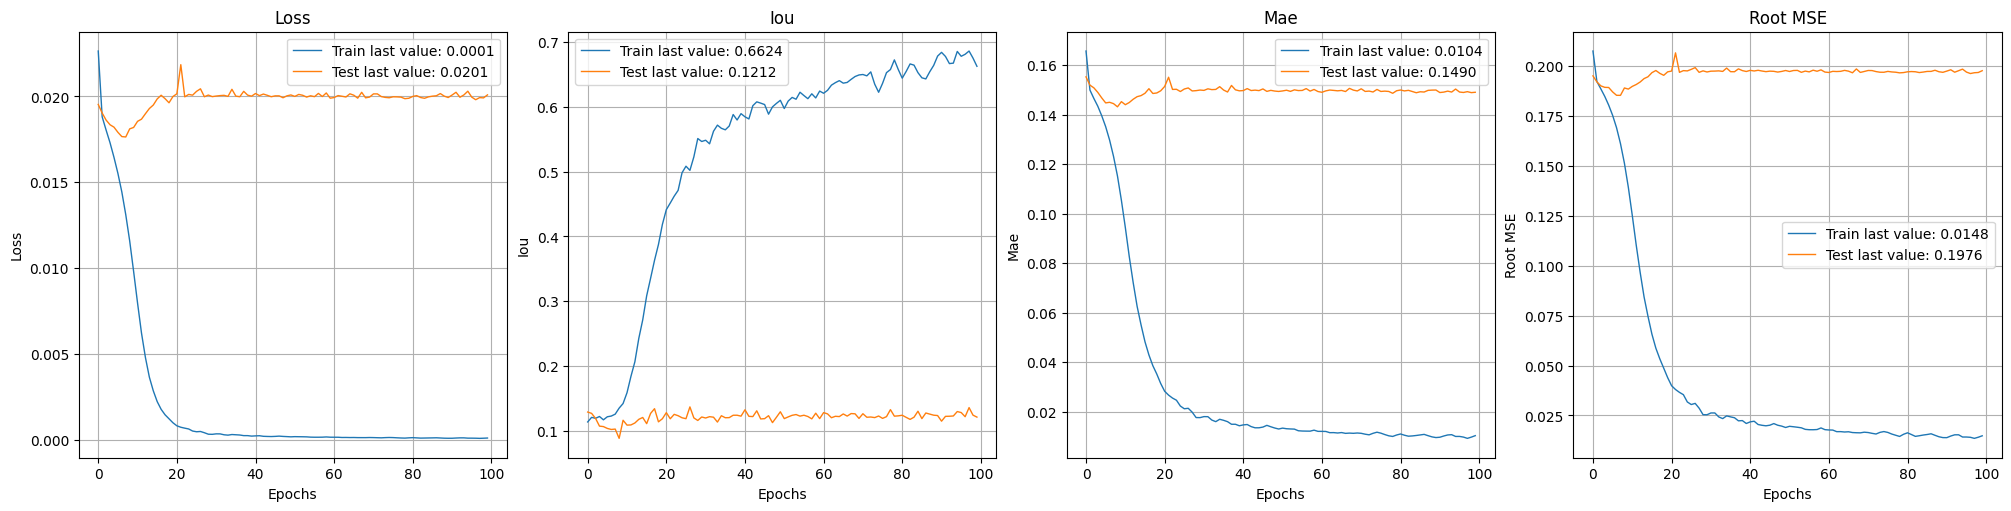

In [24]:
plot_history(history)

In [25]:
wandb.log({"train example": train_table})
wandb.log({"val example": val_table})
#os.system('rm -rf saved_images')
wandb.finish()


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iou,▁▁▁▁▂▂▃▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇██████████
loss,█▇▆▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mae,█▇▇▆▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
root_mean_squared_error,█▇▇▆▅▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_iou,▇▅▁▁▂▃▃█▇▆▅▅▅▃▅▆█▇▅▅▅▆▆▆▇▅▅▆▅▅▅▅▅▅▇▆▅▆▅▅
val_loss,▆▄▂▁▃▅▇▇█▇█▇▇▇▇▇█▇▇▇▇▇▇█▇▇▇▇█▇▇▇▇▇▇▇█▇▇▇
val_mae,█▅▁▁▁▂▄▄▆▅▅▄▅▅▅▅▅▅▅▄▄▅▅▅▄▅▄▅▄▄▄▄▄▄▄▅▄▄▄▄
val_root_mean_squared_error,▆▄▂▁▃▅▇▇█▇█▇█▇▇████▇▇▇▇█▇▇▇▇█▇▇▇▇▇▇▇██▇█
best_epoch,26
best_val_iou,0.13694
